## **MA5606 Tópicos Matemáticos en Aprendizaje de Máquinas, Redes Neuronales y Aprendizaje Profundo**

### **Actividad práctica 1**

**Profesores: Claudio Muñoz y Joaquín Fontbona**

**Auxiliares: Javier Maass y Diego Olguín**

In [1]:
# Librerías

# Numpy y matplotlib, junto con seaborn, para gráficos un poco mejores
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# PyTorch y módulos que serán necesario
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# Clase para crear redes neuronales
class NeuralNetwork(nn.Module):
    def __init__(self, dim_input, dim_output, n_layers, wide, activation) -> None:
        super().__init__()
        # Se crean las capas internas
        self.inner_layers = nn.ModuleList([nn.Linear(dim_input if n == 0 else wide, wide)
                                           for n in range(n_layers - 1)])
        # Y la última capa, o de output
        self.last_layer = nn.Linear(wide, dim_output)
        self.activation = activation

    # Función de forward, que dado un input calcula el output de la red
    def forward(self, input):

        for layer in self.inner_layers:
            input = self.activation()(layer(input)) # Efecto de activación

        return self.last_layer(input)

In [3]:
# Función a aproximar
def f(x):
    return 1/(1+torch.exp(-x))

# Generación de datos

# Cantidad de datos y dimensión
N, dim = 20, 1
size = (N, dim)

# A efectos de esta sesión fijaremos una semilla
torch.manual_seed(42)

# Datos aleatorios en x en [0, 5]
x0, xf = 0, 3
X = (xf-x0)*torch.rand(size) + x0

# Datos en y, podemos pasar un tensor a través de funciones de torch
y = f(X)

In [4]:
# Veamos la forma de cada uno de los tensores
print("X:", X)
print()
print("y:", y)

X: tensor([[2.6468],
        [2.7450],
        [1.1486],
        [2.8779],
        [1.1713],
        [1.8027],
        [0.7697],
        [2.3809],
        [2.8223],
        [0.3996],
        [2.8038],
        [1.7807],
        [2.6082],
        [1.7031],
        [2.2233],
        [1.2882],
        [2.6563],
        [1.7217],
        [0.7997],
        [1.8823]])

y: tensor([[0.9338],
        [0.9396],
        [0.7593],
        [0.9467],
        [0.7634],
        [0.8585],
        [0.6835],
        [0.9154],
        [0.9439],
        [0.5986],
        [0.9429],
        [0.8558],
        [0.9314],
        [0.8459],
        [0.9023],
        [0.7838],
        [0.9344],
        [0.8483],
        [0.6899],
        [0.8679]])


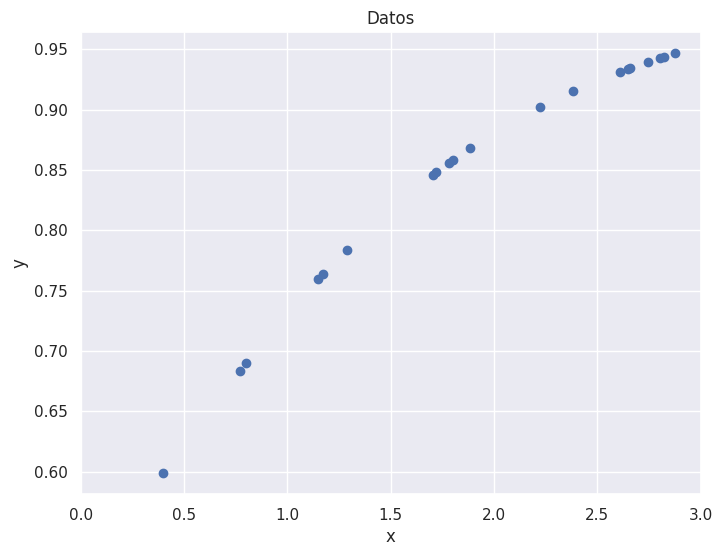

In [5]:
# Gráfico
plt.figure(figsize=(8,6))

# Debemos dejar planos los tensores para poder graficar
plt.scatter(X.squeeze(), y.squeeze())
plt.xlabel("x")
plt.ylabel("y")
plt.title("Datos")
plt.xlim(x0, xf)
plt.show()

In [6]:
n_layers = 3 # Número de capas
wide = 100 # Ancho

# Red neuronal
net = NeuralNetwork(dim_input=1,
                    dim_output=1,
                    n_layers=n_layers,
                    wide=wide,
                    activation=nn.Tanh
                )

# Optimizador
optimizer = torch.optim.Adam(net.parameters())

# Iteraciones de entrenamiento
iters = 500

# Iremos guardando la pérdida en cada época
loss_record = []

In [7]:
def calc_loss():
    # Predicción de la red
    output = net(X)

    # Calculo de la función de pérdida, en este caso es en media cuadrática
    loss = nn.MSELoss()(output, y)

    return loss

In [8]:
# Función necesaria para el optimizador
def closure():
    optimizer.zero_grad() # Se actualizan los pesos haciendo gradiente 0
    loss = calc_loss() # Se calcula la función de pérdida
    loss.backward() # Diferenciación automática
    return loss

In [9]:
try:
    for iter in range(1, iters + 1):

        # Guardamos la pérdida calculada
        loss_record.append(calc_loss().item())
        # Paso del optimizador
        optimizer.step(closure)

        # Imprimimos la pérdida en cada iteración, cada ciertas iteraciones
        if iter % 100 == 0:
            print(f'Iterations {iter} || loss: {loss_record[-1]:.4f}')

# Hacer esta sentencia try, except de esta forma hace que
# podamos parar el entrenamiento sin que haya error
except KeyboardInterrupt:
    pass

Iterations 100 || loss: 0.0002
Iterations 200 || loss: 0.0000
Iterations 300 || loss: 0.0000
Iterations 400 || loss: 0.0000
Iterations 500 || loss: 0.0000


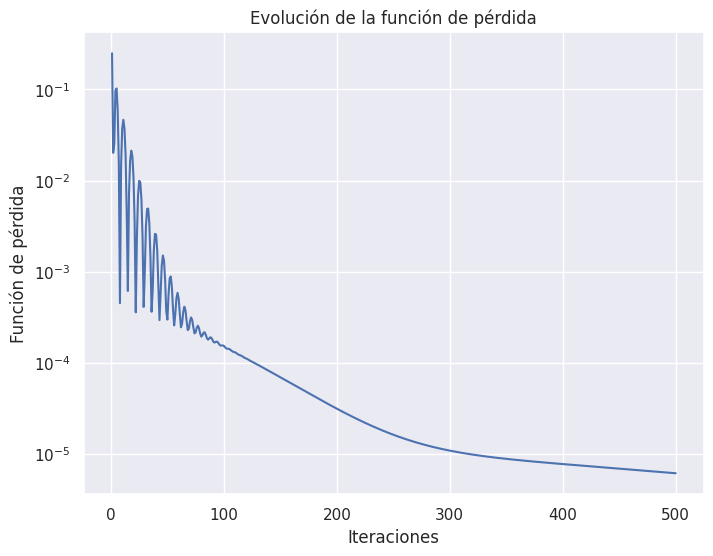

In [10]:
# Gráfico de la función de pérdida en las iteraciones
plt.figure(figsize=(8,6))
plt.plot(range(1, iters+1), loss_record)
plt.yscale("log")
plt.xlabel("Iteraciones")
plt.ylabel("Función de pérdida")
plt.title("Evolución de la función de pérdida")
plt.show()

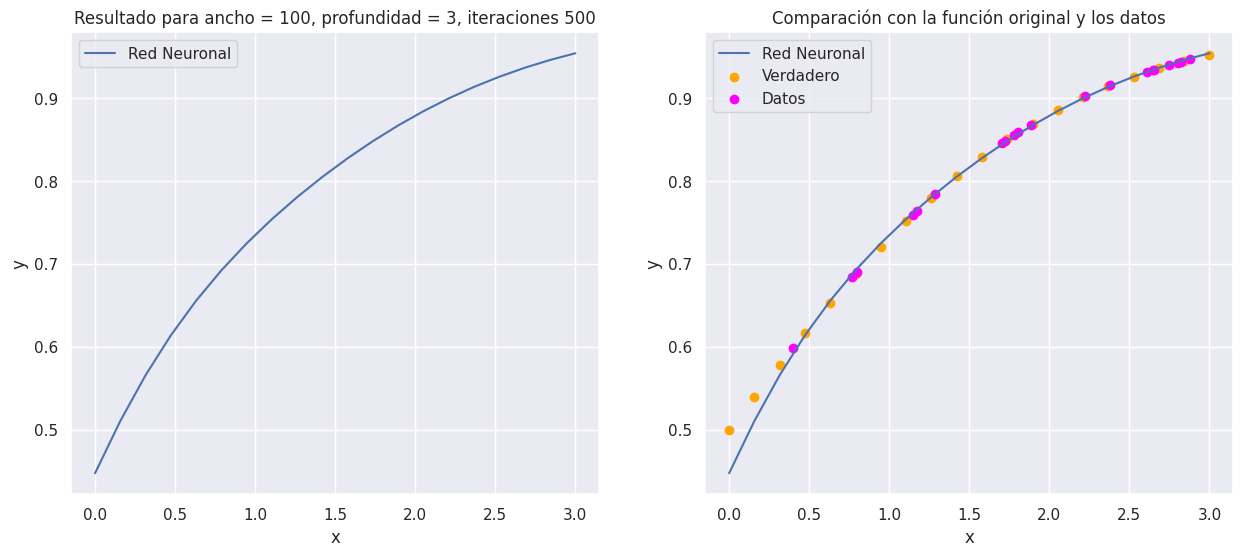

In [11]:
# Generamos datos para poder testear el resultado de la red
N_test = 20
X_test = torch.linspace(x0, xf, N_test).reshape((N_test, dim))
y_test = net(X_test).squeeze()
y_true = f(X_test).squeeze()


fix, ax = plt.subplots(1, 2, figsize=(15, 6))
# Cuando pasamos un tensor a través de una red entrenada
# debemos utilizar detach() para eliminar el grafo que se utiliza
# en la autodiferenciación
ax[0].plot(X_test, y_test.detach(), label="Red Neuronal")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Resultado para ancho = {}, profundidad = {}, iteraciones {}".format(wide, n_layers, iters))
ax[0].legend()

ax[1].plot(X_test, y_test.detach(), label="Red Neuronal")
ax[1].scatter(X_test, y_true, label="Verdadero", c="orange")
ax[1].scatter(X, y, label="Datos", c="magenta")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Comparación con la función original y los datos")
ax[1].legend()
plt.show()

Vemos que la red logra ajustar muy bien en los puntos de entrenamiento, aún así, y es claro del hecho de que solo le estamos pidiendo optimizar sobre unos puntos dados, no logra aproximar bien a la función subyacente (o verdadera). Esto se puede mejorar notoriamente si le damos a la red:

* Más datos.
* Más información de la función que queremos aproximar, por ejemplo si satisface una ecuación diferencial.

Nos centraremos en esta segunda, lo que también se puede ver como una forma de aproximar soluciones de ecuaciones diferenciales.

### **Physics-Informed Neural Networks (PINNs)**

Ahora veremos como incorporar información "física" al problema, que es incluir una ecuación al problema, como una EDO o una EDP. El nombre del método, y la metodología utilizada, se le atribuye a M. Raissi, P. Perdikaris, G.E. Karniadakis $^1$.

Si tenemos un problema de Cauchy de la forma (o uno equivalente, como un problema de frontera)

\begin{align*}
    y' & = f(t, y), \quad t \in (0, T) \\
    y(0) & = y_0
\end{align*}

Con $y_0 \in \mathbb{R}^n$, $T > 0$ y $f:[0, T] \times  \mathbb{R}^n \to  \mathbb{R}^n$ una función continua y Lipschitz con respecto a su segunda variable, globalmente. Es decir, supondremos que se satisfacen las hipótesis de TEU global.

La idea es encontrar una red neuronal $y_\theta$ que aproxime a la solución de la EDO. Esto se puede lograr encontrando, si es posible, unos parámetros $\theta$ que minimicen la función de pérdida

$$ \mathcal{L} = \lambda_\text{physics} \frac{1}{M} \sum_{k=0}^M \left ( \frac{dy_\theta}{dt}(t_i) - f(t_i, y_\theta (t_i)) \right )^2 + \lambda_\text{initial}(y_\theta (0) - y_0)^2$$

Donde $M$ es la cantidad puntos que se tomarán en el intervalo $[0, T]$ y $\lambda_\text{physics}$, $\lambda_\text{initial} \geq 0$ son los pesos que se le da a cada sumando en la función de pérdida, que desglosamos como:

* Residuo de la EDO (o función de pérdida en la física del problema):

$$\frac{1}{M} \sum_{k=0}^M \left ( \frac{dy_\theta}{dt}(t_i) - f(t_i, y_\theta (t_i)) \right )^2$$

* Residuo de la condición inicial (o función de pérdida en la condición inicial):

$$(y_\theta (0) - y_0)^2$$

Es decir, se está forzando a que la red neuronal satisfaga la EDO y también la condición inicial. Los ponderadores $\lambda_\text{physics}$, $\lambda_\text{initial}$ juegan un rol importante, ya que aquel que sea mayor forzará a que la red se ajuste más a la física o la condición inicial.

Debido a que a la red neuronal se le da tanto información conocida de la función, la condición inicial, como la física que cumple, se dice que la red siendo "informada por la física" y de ahí su nombre, que ahora abreviaremos como PINNs.

$^1:$ *M. Raissi, P. Perdikaris, G.E. Karniadakis; Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations.*


Aplicaremos esto al siguiente problema

$$ y'(x) = y(x) (1+y(x)), \quad x \in [0, 5] $$
$$ y(0) = 1/2$$

Que tiene como solución analítica

$$ y(x) = \frac{1}{1+e^{-x}} $$

Algo que es clave en este enfoque es calcular la derivada temporal de la red neuronal $y_\theta$. Esto es fácil y eficiente en este contexto, ya que estos frameworks tienen implementado un algoritmo de autodiferenciación, no se profundizará en esto, pero es una gran ventaja del método ya que permite calcular derivadas con respecto a algún parámetro o input de manera rápida basada en grafos.

In [12]:
# Función que dado un tensor que representa una función f, le calcula
# su gradiente con respecto a la variable que se le entregue en forma
# de tensor

def derivative(f, variable):
    return torch.autograd.grad(f.sum(), variable, create_graph=True)[0]

Ahora se define una función que calcule el residuo de la EDO, en este caso es

$$\mathcal{R} =  \frac{dy_\theta}{dt} - f(x_n, y_\theta)$$

In [13]:
# Función que calcula el residuo de la EDO

def ODE(x, net):
    y = net(x).unsqueeze(0)
    dy = derivative(y, x)
    return dy - y*(1-y)

In [14]:
# Solución analítica

def y_analitica(x):
    return 1/(1+torch.exp(-x))

Ahora creamos y entrenamos la red igual que antes, pero ahora debemos simplemente crear otra función de pérdida.

In [15]:
n_layers = 3 # Número de capas
wide = 100 # Ancho

# Dimensiones de entrada y salida, que serán iguales en este caso
dim_input = 1
dim_output = 1

# Red neuronal
net = NeuralNetwork(dim_input, dim_output, n_layers, wide, nn.Tanh)

# Optimizador
optimizer = torch.optim.Adam(net.parameters())

# Pesos de las funciones de pérdida
weights = (1, 1)

# Valor inicial
y_initial = 1/2

# Iteraciones de entrenamiento
iters = 600

# Discretización en tiempo
samples_phys = 300

# Iremos guardando la pérdida en cada época
loss_record = []

Haremos diferencia entre la pérdida asociada al único dato conocido (el único!) y la pérdida asociada al residuo de la EDO.

In [16]:
# Posiciones en x a evauar
x_initial = torch.zeros(1, 1)

# Tiempo para evaluar lo que devuelve el residuo de la EDO
x_phys = torch.linspace(0, 2, samples_phys).reshape((samples_phys, 1)).requires_grad_()

def calc_loss():

    ####
    # Pérdida en la condición inicial
    ####

    # Predicción en el medio
    output_initial = net(x_initial).unsqueeze(0)

    # Objetivo o target, es lo que debería dar, en este caso
    # la condición inicial real
    target_initial = torch.ones(1, 1, 1)*y_initial

    # Cálculo de la perdida en la condición inicial
    loss_initial = nn.MSELoss()(output_initial, target_initial)

    ####
    # Pérdida en la EDO o la física
    ####

    # Evaluación de la red en el residuo de la EDO
    output_phys = ODE(x_phys, net)

    # Objetivo, nos debería dar 0 el residuo
    target_phys = torch.zeros_like(output_phys)

    # Cálculo de la perdida en el residuo de la EDO
    loss_phys = nn.MSELoss()(output_phys, target_phys)

    ####
    # Pérdida total
    ####

    # Cálculo de la función de pérdida total
    loss =  weights[0]*loss_phys + weights[1]*loss_initial

    return loss

In [17]:
# Función necesaria para el optimizador
def closure():
    optimizer.zero_grad() # Se actualizan los pesos haciendo gradiente 0
    loss = calc_loss() # Se calcula la función de pérdida
    loss.backward() # Diferenciación automática
    return loss

Hacemos el entrenamiento de la red.

In [18]:
try:
    for iter in range(1, iters + 1):

        # Guardamos la pérdida calculada
        loss_record.append(calc_loss().item())
        # Paso del optimizador
        optimizer.step(closure)

        # Imprimimos la pérdida en cada iteración, cada ciertas iteraciones
        if iter % 100 == 0:
            print(f'Iterations {iter} || loss: {loss_record[-1]:.4f}')

# Hacer esta sentencia try, except de esta forma hace que
# podamos parar el entrenamiento sin que haya error
except KeyboardInterrupt:
    pass

Iterations 100 || loss: 0.0000
Iterations 200 || loss: 0.0000
Iterations 300 || loss: 0.0000
Iterations 400 || loss: 0.0000
Iterations 500 || loss: 0.0000
Iterations 600 || loss: 0.0000


Graficamos la pérdida en las iteraciones de entrenamiento.

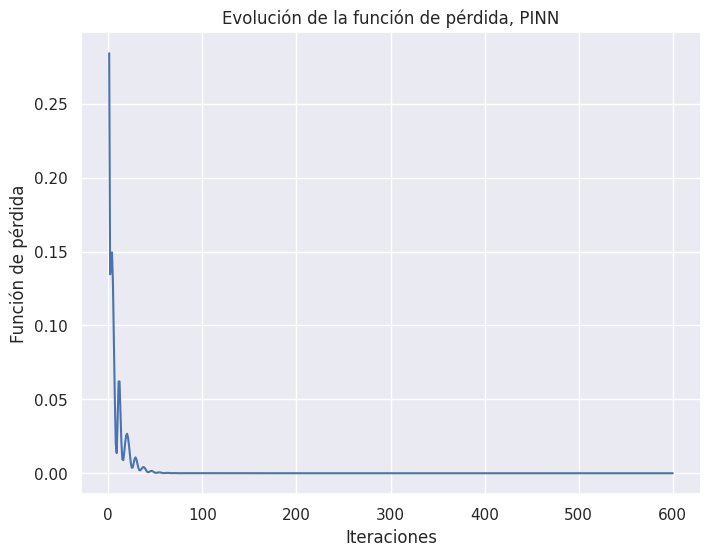

In [19]:
# Gráfico de la función de pérdida en las iteraciones
plt.figure(figsize=(8,6))
plt.plot(range(1, iters+1), loss_record)
plt.xlabel("Iteraciones")
plt.ylabel("Función de pérdida")
plt.title("Evolución de la función de pérdida, PINN")
plt.show()

Graficamos el resultado de la red.

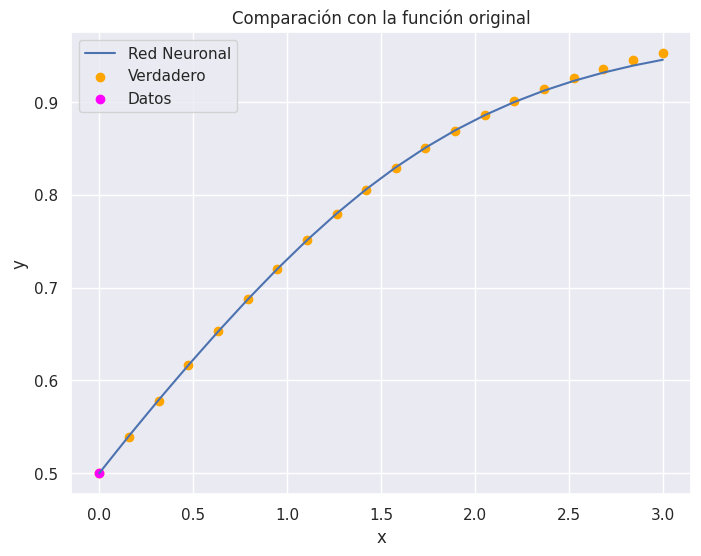

In [20]:
# Generamos datos para poder testear el resultado de la red
N_test = 20
X_test = torch.linspace(x0, xf, N_test).reshape((N_test, dim))
y_test = net(X_test).squeeze()
y_true = y_analitica(X_test).squeeze()

datax = [x_initial[0][0]]
datay = [net(x_initial).detach()[0][0]]

fix, ax = plt.subplots(1, 1, figsize=(8, 6))
# Cuando pasamos un tensor a través de una red entrenada
# debemos utilizar detach() para eliminar el grafo que se utiliza
# en la autodiferenciación
ax.plot(X_test, y_test.detach(), label="Red Neuronal")
ax.scatter(X_test, y_true, label="Verdadero", c="orange")
ax.scatter(datax, datay, c="magenta", label="Datos")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Comparación con la función original")
ax.legend()
plt.show()

Vemos que la red mejora mucho su resultado al entregarle información sobre la EDO que satisface, incluso con solo 3 datos!

### **PINNs en EDP**

Un código análogo al anterior se puede hacer para EDP, en donde se incluye ahora el factor de tener que trabajar en dominios en 2D o 3D, adicional al tiempo. Esto se puede programar, pero a efecto práctico utilizaremos la librería DeepXDE.

Esta librería se ha utilizado mucho el último tiempo en papers relacionados con PINNs y Physics-Informed Machine Learning, por lo que está dentro del *estado del arte*.

Pros:
* Facilita muchas tareas relacionadas con PINNs al máximo posible.
* Tiene una notación similar a otros solvers de EDP como FEniCS.
* Admite varios backends, principalmente PyTorch y TensorFlow.

Contras:
* Es de muy alto nivel, es decir, a cambio de las facilidades de uso sacrifica mucho control sobre ciertos factores de entrenamiento y manejo sobre las redes en sí mismas.

In [21]:
# Instalamos e importamos la librería
try:
    import deepxde as dde
except:
    !pip install deepxde
    import deepxde as dde

# Importamos Tensorflow, que es el backend que utilizaremos
import tensorflow as tf

2024-04-10 13:22:26.471969: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 13:22:26.473924: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-10 13:22:26.496614: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 13:22:27.021217: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more 

Resolveremos el siguiente problema de EDP de Helmholtz vía redes neuronales

$$ -\Delta u - k_0^2 u = f, \quad \Omega = (0,1)^2 $$
$$ u = 0, \quad ∂ Ω $$

Donde $k_0$ es el número de ondas. Si $f(x,y) = k_0^2 \sin (k_0 x) \sin (k_0 y)$, entonces el problema tiene solución analítica

$$ u(x, y) =  \sin (k_0 x) \sin (k_0 y)$$.

En este problema se debe considerar la pérdida asociada a la ecuación y otra asociada a la frontera. Daremos un enfoque que funciona muy bien en la práctica para que la pérdida asociada a la frontera no se vea superada por la del dominio. Para ello, en vez de entrenar la red, entrenaremos una transformación de la red que satisfaga inmediatamente la condición de borde

$$ \hat u _\theta (x, y) = x(1-x)y (1-y) u_\theta (x,y) $$

Esto se denota por *hard constraint*.

In [59]:
# Dimensión de input
dim_input = 2

# Dimensión de output
dim_output = 1

# Iteraciones del optimizador
iterations = 10000

# Número de onda
n = 2
k0 = 2 * np.pi * n




Entre las grandes ventajas de DeepXDE, está la facilidad para definir la geometría, su frontera (o distintas fronteras) y la condición de borde.

In [60]:
# Geometría
geom = dde.geometry.Rectangle([0, 0], [1, 1])

# Frontera
def boundary(_, on_boundary):
    return on_boundary

# Dado que fijaremos la condición de borde, no se la daremos a la red directamente
bc = []

Hay que definir la ecuación.

In [61]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)

    f = k0 ** 2 * tf.sin(k0 * x[:, 0:1]) * tf.sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0 ** 2 * y - f

Armamos los datos necesarios para la ecuación.

In [62]:
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=400
)

Ahora armamos la red.

In [63]:
# Parámetros de la red
wide, n_layers, activation = 150, 3, "sin"

# Red neuronal
net = dde.nn.FNN(
    [dim_input] + [wide] * n_layers + [dim_output], activation, "Glorot uniform"
)

Definiremos la transformación para fijar la condición de borde y la aplicamos a la red.

In [64]:
# Transformación
def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y

# La aplicamos
net.apply_output_transform(transform)


Creamos el modelo con los datos necesarios y la red.

In [65]:
# Creamos el modelo
model = dde.Model(data, net)

# Compilamos indicando el optimizador
loss_weights = [1, weights]
model.compile(
    "adam",
    lr=1e-3
)

Compiling model...
'compile' took 0.001471 s



Y para entrenar todo se hace en una línea.

In [66]:
# Entrenamos
losshistory, train_state = model.train(iterations=iterations, display_every=50)

Training model...



Step      Train loss    Test loss     Test metric
0         [6.25e+03]    [6.25e+03]    []  
50        [6.25e+03]    [6.25e+03]    []  
100       [6.25e+03]    [6.25e+03]    []  
150       [6.25e+03]    [6.25e+03]    []  
200       [6.25e+03]    [6.25e+03]    []  
250       [6.25e+03]    [6.25e+03]    []  
300       [6.25e+03]    [6.25e+03]    []  
350       [6.25e+03]    [6.25e+03]    []  
400       [6.25e+03]    [6.25e+03]    []  
450       [6.24e+03]    [6.24e+03]    []  
500       [5.80e+03]    [5.80e+03]    []  
550       [5.44e+03]    [5.44e+03]    []  
600       [5.05e+03]    [5.05e+03]    []  
650       [4.84e+03]    [4.84e+03]    []  
700       [4.65e+03]    [4.65e+03]    []  
750       [4.24e+03]    [4.24e+03]    []  
800       [2.49e+03]    [2.49e+03]    []  
850       [8.41e+02]    [8.41e+02]    []  
900       [4.37e+02]    [4.37e+02]    []  
950       [2.73e+02]    [2.73e+02]    []  
1000      [1.75e+02]    [1.75e+02]    []  
1050      [1.18e+02]    [1.18e+02]    []  
1100

Podemos graficar también la función de pérdida en las iteraciones

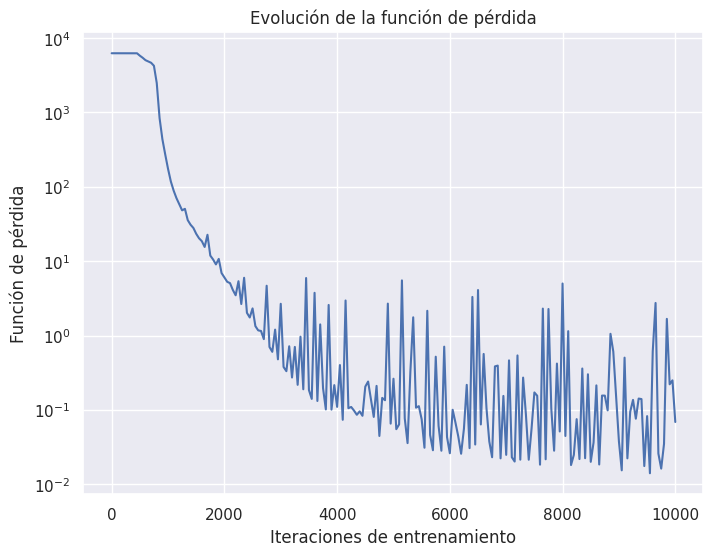

In [72]:
plt.figure(figsize=(8, 6))
plt.plot(losshistory.steps, losshistory.loss_train)
plt.yscale("log")
plt.xlabel("Iteraciones de entrenamiento")
plt.ylabel("Función de pérdida")
plt.title("Evolución de la función de pérdida")
plt.show()

Comparamos con la solución exacta.

In [68]:
def u_exact(x, y):
    return np.sin(k0*x)*np.sin(k0*y)

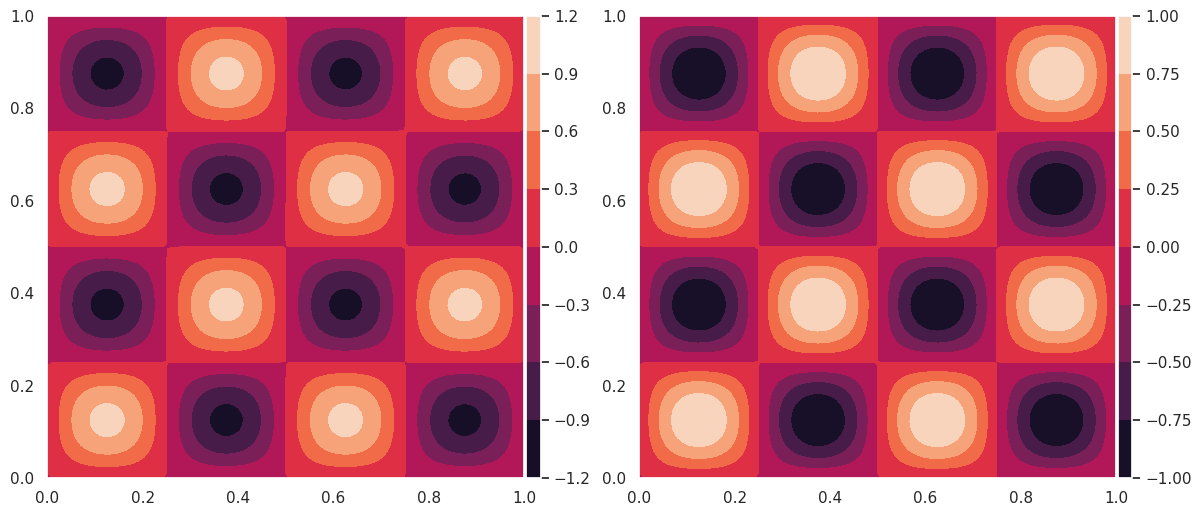

In [69]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

x0, xf, y0, yf = 0, 1, 0, 1
Nx, Ny = 100, 100
x, y = np.linspace(x0, xf, Nx), np.linspace(y0, yf, Ny)

arrays = [np.vstack((x,np.ones(Nx)*y[i])) for i in range(Ny)]
X_ = np.hstack(arrays)
u = model.predict(X_.T)

X, Y = np.meshgrid(x, y)

U_exact = u_exact(X, Y)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

c1 = ax[0].contourf(X, Y, u.reshape((Nx, Ny)))

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='3%', pad=0.02)
fig.colorbar(c1, cax=cax, orientation='vertical')

c2 = ax[1].contourf(X, Y, U_exact)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='3%', pad=0.02)
fig.colorbar(c2, cax=cax, orientation='vertical')

plt.show()